# 데이터셋 준비하기

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.image as image
from matplotlib.pyplot import imshow
%matplotlib inline
import numpy as np

In [3]:
# GPU 환경 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manuual_seed_all(777)

In [4]:
trans = transforms.Compose([
  transforms.Resize([64, 128]), # 높이 64, 너비 128
  transforms.ToTensor()
])

In [5]:
project_path = './dataset/original_data'
original_data = torchvision.datasets.ImageFolder(root = project_path , transform=trans)

In [6]:
from sklearn.model_selection import train_test_split

# train, test split
train_data,test_data = train_test_split(original_data, test_size=0.3)

# Neural Network 만들기
input data는 channel = 3, height = 64, width = 128

layer1,2에는 conv2d, ReLU, MaxPool

layer 3에는 view FC(Fully Connected)1, ReLU, FC2

loss 계산은 분류 문제이므로 Cross Entropy Loss로 하겠다.

In [7]:
data_loader = DataLoader(dataset=train_data, batch_size = 8, shuffle = True, num_workers=2)

라벨링을 한글로 하면 plt.show()시 오류가 발생하여 이니셜로 바꿔주었다.

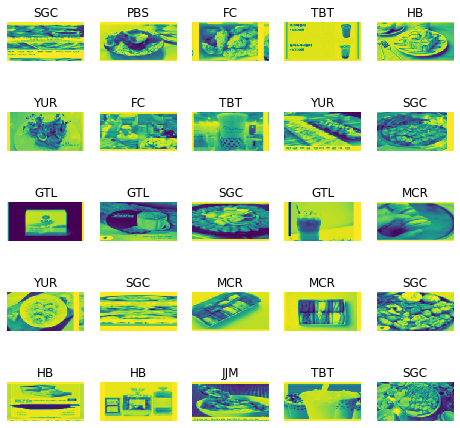

In [8]:
#닭갈비, 소곱창, 연어롤, 짜장면, 후라이드치킨, 그린티 라떼, 타로 버블티,  허니브레드, 팥빙수, 마카롱
labels_map = {0:'DKB', 1:'SGC', 2:'YUR', 3:'JJM', 4:'FC', 5:'GTL', 
              6:'TBT', 7:'HB',8:'PBS',9:'MCR'}
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(train_data))
    img = train_data[data_idx][0][0,:,:].numpy() # numpy()를 통해 torch Tensor를 numpy array로 변환
    label = labels_map[train_data[data_idx][1]] # item()을 통해 torch Tensor를 숫자로 변환
    
    fig.add_subplot(rows, columns, i)
    plt.title(label)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, 5),  ##입력채널 6개,출력채널 6개, 필터 size 5. stride = default(=1)
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(16*13*29, 120),
            nn.ReLU(),
            nn.Linear(120, 10)
        )
    def forward(self, x):
        out = self.layer1(x)
        #print(out.shape) 
        out = self.layer2(out)
        #print(out.shape)
        out = out.view(out.shape[0], -1)
        #print(out.shape)
        out = self.layer3(out)
        return out

In [10]:
# 모델의 input, output size 잘 맞춰줬는지 확인
net = CNN().to(device)
test_input = (torch.Tensor(3, 3, 64, 128)).to(device)
test_out=net(test_input)

In [11]:
optimizer = optim.Adam(net.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss().to(device)

In [12]:
total_batch = len(data_loader)
epochs = 30
for epoch in range(epochs):
    arg_cost = 0.0
    for num, data  in enumerate(data_loader):
        imgs, labels = data
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
    
        out = net(imgs)
        cost = criterion(out, labels)
    
        cost.backward()
        optimizer.step()

        arg_cost += cost/total_batch
    print('Epoch {} :: cost = {}'.format(epoch+1, arg_cost))
print("학습 완료.")

Epoch 1 :: cost = 2.1275501251220703
Epoch 2 :: cost = 1.8778761625289917
Epoch 3 :: cost = 1.6847103834152222
Epoch 4 :: cost = 1.4286748170852661
Epoch 5 :: cost = 1.1301708221435547
Epoch 6 :: cost = 0.8257971405982971
Epoch 7 :: cost = 0.5211809277534485
Epoch 8 :: cost = 0.35154205560684204
Epoch 9 :: cost = 0.203520730137825
Epoch 10 :: cost = 0.1488059163093567
Epoch 11 :: cost = 0.12864330410957336
Epoch 12 :: cost = 0.14868558943271637
Epoch 13 :: cost = 0.11516419798135757
Epoch 14 :: cost = 0.09756142646074295
Epoch 15 :: cost = 0.09538845717906952
Epoch 16 :: cost = 0.11593323945999146
Epoch 17 :: cost = 0.05573636665940285
Epoch 18 :: cost = 0.06290210038423538
Epoch 19 :: cost = 0.10410749912261963
Epoch 20 :: cost = 0.1369287371635437
Epoch 21 :: cost = 0.07988032698631287
Epoch 22 :: cost = 0.10054771602153778
Epoch 23 :: cost = 0.06542021781206131
Epoch 24 :: cost = 0.04876993969082832
Epoch 25 :: cost = 0.039494432508945465
Epoch 26 :: cost = 0.03772207349538803
Epoch

# 학습시킨 모델 저장하기

In [13]:
torch.save(net.state_dict(), './model/model.pth')

In [14]:
new_net = CNN().to(device)

In [15]:
# 학습된 값 불러오기.
new_net.load_state_dict(torch.load('./model/model.pth'))

<All keys matched successfully>

In [16]:
# 내가 이전에 저장했던 그 모델이 맞는지 확인하는 코드.
print(net.layer1[0])
print(new_net.layer1[0])

print(net.layer1[0].weight[0][0][0])
print(new_net.layer1[0].weight[0][0][0])

net.layer1[0].weight[0] == new_net.layer1[0].weight[0]

Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
tensor([-0.1187,  0.0029, -0.0019, -0.0252,  0.0576], grad_fn=<SelectBackward>)
tensor([-0.1187,  0.0029, -0.0019, -0.0252,  0.0576], grad_fn=<SelectBackward>)


tensor([[[True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True]],

        [[True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True]],

        [[True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True],
         [True, True, True, True, True]]])

# 모델 테스트 하기

In [17]:
test_set = DataLoader(dataset = test_data, batch_size = len(test_data))

In [18]:
with torch.no_grad():
    for num, data in enumerate(test_set):
        imgs, label = data
        imgs = imgs.to(device)
        label = label.to(device)
        
        prediction = net(imgs)
        
        correct_prediction = torch.argmax(prediction, 1) == label
        
        accuracy = correct_prediction.float().mean()
        print('Accuracy:', accuracy.item())

Accuracy: 0.37555554509162903


(10가지 분류 중에 하나를 무작위로) 찍었을 때의 정확도인 10% 보다는 나아보인다. 신경망이 뭔가 배우긴 했다는 것이다.하지만 좋은 수치라고는 볼 수 없다.

일단 시간이 부족하여 구글 이미지를 크롤링했는데, 상태가 좋지 않은 이미지가 많이 뒤섞여 들어간 점을 감안하였으면 좋겠다. 향후 이미지 정제와, convolutional layer의 크기와 개수를 조정하여 정확치를 높일 것이다.

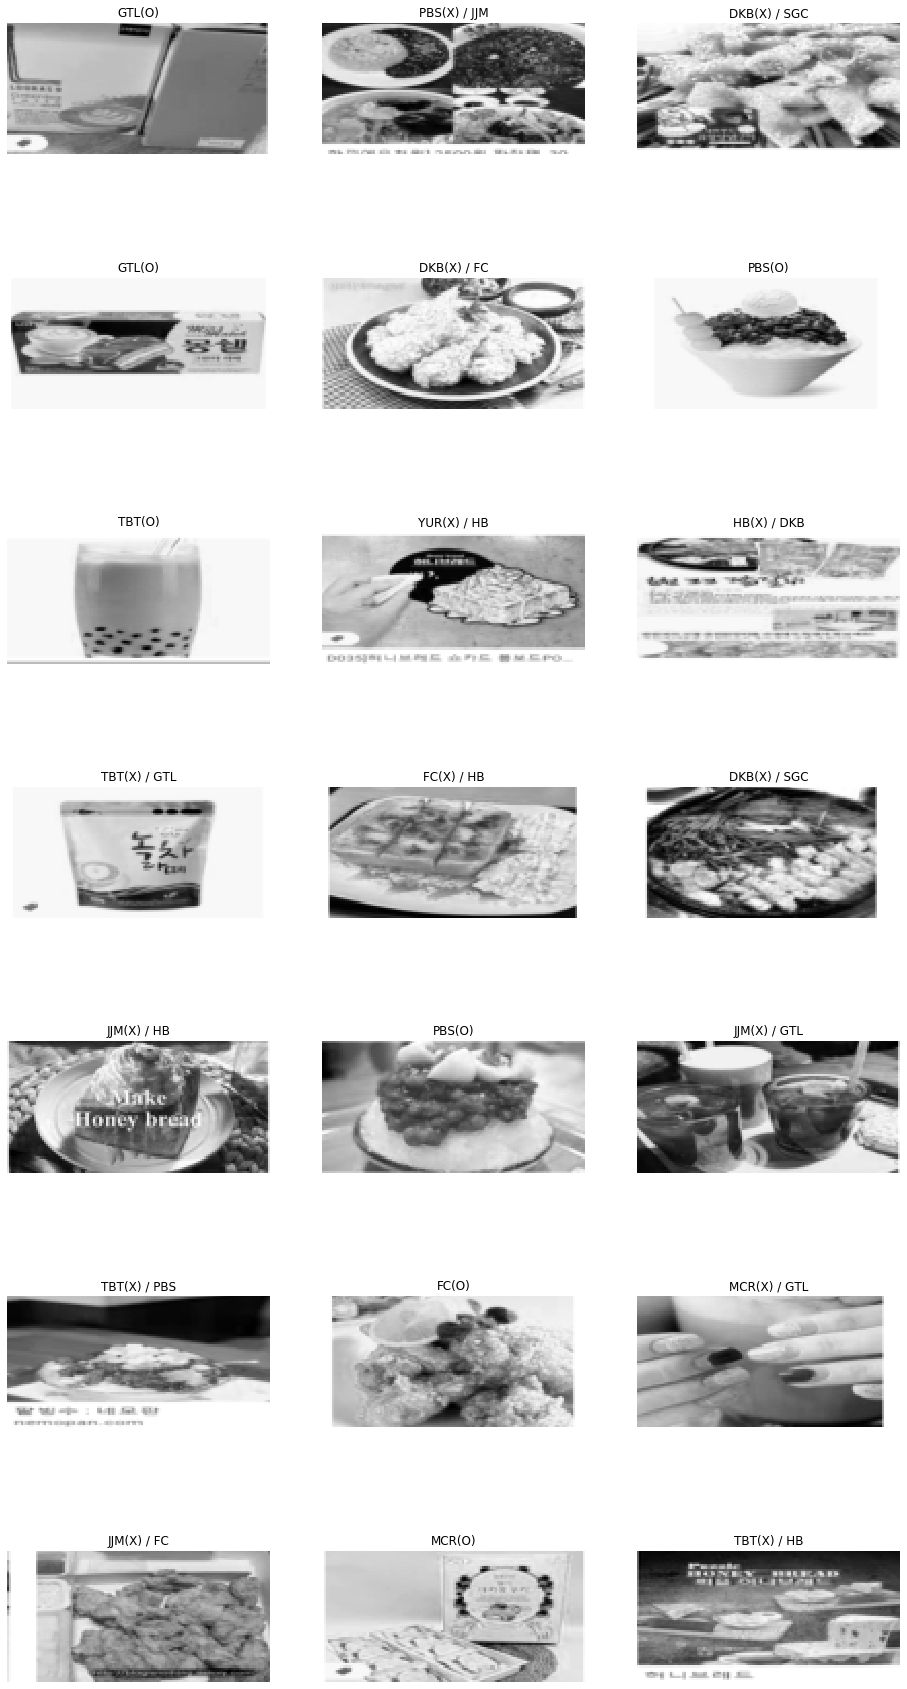

In [19]:
columns = 3
rows = 7
fig = plt.figure(figsize=(16,32))

net.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(device) 
    output = net(input_img)
    _, argmax = torch.max(output, 1)
    pred = labels_map[argmax.item()]
    label = labels_map[test_data[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + '(O)')
    else:
        plt.title(pred + '(X)' + ' / ' + label)
    plot_img = test_data[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap='gray')
    plt.axis('off')
net.train()
plt.show()